# Topic Extraction, NMF

## Überblick

Wir betrachten Low-Rank-Matrix-Approximationen. Mit deren Hilfe versuchen wir aus einer Menge von Texten "Themen" zu extrahieren ("Topic Extraction").

## Grundlagen

Wir betrachten eine Menge von Texten und stellen diese zunächst in Form einer Matrix $V$ dar. Für jeden Text legen wir eine Spalte an, für jedes Wort eine Zeile und $v_{ij}$
enthält dann die (skalierte) Häufigkeit, wie oft das $i$-te Wort im $j$-ten Text auftaucht.

Um wiederkehrende Strukturen (Cluster) in den Texten zu identifizeren kann man nun versuchen, die Matrix $V \in \mathbb{R}^{m \times n}$ zu zerlegen in
\begin{equation*} 
V = WH,
\quad
W \in \mathbb{R}^{m \times k},
\quad
H \in \mathbb{R}^{k \times n},
\quad
k \le \min(m,n).
\end{equation*}
Wenn $k\ll \min(m,n)$, dann können wir die Texte in $V$ mit Hilfe
der "Basistexte" in den Spalten von $W$ erzeugen. Die Spalten von $W$
stellen dann bestimmte "Topics" dar, die Spalten von $H$ geben an, wie
diese Topics linear kombiniert werden, um den jeweiligen Ausgangstext zu erzeugen.

In den seltensten Fällen wird eine exakte Zerlegung $V=WH$ möglich sein. Deshalb gibt man sich mit einer approximativen Zerlegung zufrieden, d.h. man sucht
\begin{equation*} 
\text{argmin}_{W,H}\|V-WH\|, 
\end{equation*}
\begin{equation*} 
W \in \mathbb{R}^{m \times k},
\quad
H \in \mathbb{R}^{k \times n},
\quad
k \le \min(m,n).
\end{equation*}

Je nachdem welche Matrixnorm dabei verwendet wird, erhält man unterschiedliche Ergebnisse.
Für $\|\cdot\|_2$ und $\|\cdot\|_\text{Fro}$ zeigt man, dass die Lösung dieses Problem durch TSVD gegeben ist
(Satz von Eckart-Young-Mirsky), d.h. ist
\begin{equation*} 
V = \tilde{U}\tilde{\Sigma} \tilde{V}^T
\end{equation*}
eine SVD von $V$ und
\begin{equation*} 
\tilde{U}_k\tilde{\Sigma}_k \tilde{V}_k^T
\end{equation*}
eine TSVD,
dann löst
\begin{equation*} 
W = \tilde{U}_k\tilde{\Sigma}_k,
\quad
H = \tilde{V}_k^T
\end{equation*}
bzw.
\begin{equation*} 
W = \tilde{U}_k,
\quad
H = \tilde{\Sigma}_k \tilde{V}_k^T
\end{equation*}
das Matrix-Approximationsproblem.

Dieser Zugang hat einige Nachteile:

- die Lösung ist offensichtlich nicht eindeutig

- die Matrix $V$ ist in der Regel sparse, die TSVD nicht mehr

- für die Matrix $V$ gilt $v_{ij}\ge 0$, für $W,H$ aus TSVD gilt dies in der Regel
  nicht mehr, was die Interpretation der Ergebnisse erschwert

## NMF

Aus den oben genannten Gründen sucht man deshalb
für $k \le \min(m,n)$
eine Rang-$k$-Zerlegung von $V$ in nichtnegative Faktoren $W,H$,
die sogenannte *Nonnegative-Matrix-Factorisation* (NMF),
d.h.
\begin{equation*} 
\text{argmin}_{W,H}\|V-WH\|, 
\end{equation*}
\begin{equation*} 
W \in \mathbb{R}^{m \times k},
\quad
H \in \mathbb{R}^{k \times n},
\quad
w_{ij}, h_{ij}\ge 0,
\end{equation*}
Dieses Problem ist nach wie vor nicht eindeutig lösbar
($WH = WA^{-1}AH$), außerdem gibt es dafür keinen Zugang
aus der linearen Algebra, der analog zur TSVD für bestimmte Normen
eine Lösung liefert. Allerdings kann man dafür sorgen, dass
man die Sparsity der Matrizen beibehält.

Approximationen werden iterativ berechnet. 
An dem folgenden Beispiel werden wir unterschiedliche Zugänge ausprobieren.

## Beispiel

`sklearn` enthält den Datensatz `fetch_20newsgroups`, eine Sammlung von Newsgroup-Artikeln
zu verschiedenen Themenbereichen.
Wir laden Artikel aus mehreren Teilbereichen und versuchen daraus (ohne weitere
Zusatzinformation, also "unsupervised") "Themen" zu extrahieren, d.h.
Gruppen von Wörter, die in der Regel zusammen in einem Text auftauchen.

Wir laden zunächst die Daten. 

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

seed = 17

from IPython.display import Math
%precision 5
np.set_printoptions(precision=5)


from sklearn.datasets import fetch_20newsgroups

categories = ['rec.autos', 'sci.space','sci.med']
remove = ('headers', 'footers', 'quotes')

train = fetch_20newsgroups(subset='train', remove=remove, categories=categories)
#test  = fetch_20newsgroups(subset='test' , remove=remove, categories=categories)

print("\n\n***************\n".join(train.data[:5]))


A(>  Can anyone tell me if a bloodcount of 40 when diagnosed as hypoglycemic is
A(>  dangerous, i.e. indicates a possible pancreatic problem?  One Dr. says no, the
A(>  other (not his specialty) says the first is negligent and that another blood
A(>  test should be done.  Also, what is a good diet (what has worked) for a hypo-
A(>  glycemic?  TIA.
A(>  
A(>  
A(>  Anthony Anello
A(>  Fermilab
A(>  Batavia, Illinois

   Once you have your hypoglycemia CONFIRMED through the proper 
   channels, you might consider ther following:

   1) Chelated Manganese   25-50mg/day.
   2) Chelated Chromium    400-600mcg/day.
   3) Increase protein through foods or supplements.
   4) Avoid supplements/foods high in Potassium, Calcium, Zinc.
   5) Avoid Vit C supplements in excess of 100mg.
   6) Avoid honey and foods high in simple sugars.
   7) Enjoy breads, cereals, grains...

   Discuss the above with your health practitioner for compatibility
   with your body chemistry and safety.

   --Ron--

**

Die zugehörigen Themengruppen sind

In [2]:
np.array(train.target_names)[train.target[:5]]

array(['sci.med', 'rec.autos', 'rec.autos', 'sci.med', 'rec.autos'],
      dtype='<U9')

Jetzt erstellen wir eine Term-Document-Matrix $V$. $v_{ij}$ ist eine (skalierte Variante)
der relativen Häufigkeit des Wortes $i$ im Dokument $j$

 Typ = <class 'scipy.sparse.csc.csc_matrix'>
 Shape = (2000, 1781)
 Nonzeros = 64195


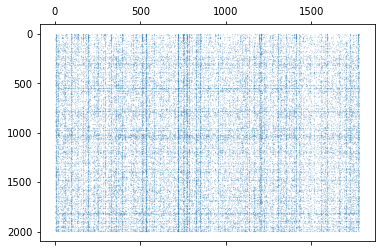

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_f = 2000
tv = TfidfVectorizer(max_df=0.95, min_df=2, max_features=max_f, stop_words='english')

V = tv.fit_transform(train.data).T

print(' Typ = {}\n Shape = {}\n Nonzeros = {}'.format(type(V), V.shape, V.nnz))

plt.spy(V, marker = '.', markersize = .1);
plt.axis('auto');

Wir speichern uns noch die Wortliste zwischen.

In [4]:
voc = np.array(tv.get_feature_names())
voc[-10:]

array(['written', 'wrong', 'wrote', 'yeah', 'year', 'years', 'yeast',
       'yes', 'york', 'young'], dtype='<U14')

Wir berechnen nun NMFs mit Parameter

In [5]:
k = 10
print('k = {}'.format(k))

k = 10


## NMF über Gradient-Descent

Ist $A*B$ die komponentenweise Multiplikation der Matrizen $A$, $B$, dann minimieren wir
die Zielfunktion
\begin{equation*} 
l(E,F) = \|V-(E*E)(F*F)\|_\text{Fro}^2. 
\end{equation*}
und setzen
\begin{equation*} 
W = E*E, \quad H=F*F
\end{equation*}
$l$ ist differenzierbar, die Nebenbedingung (Nicht-Negativität von $W,H$) ist in $l$ "eingebaut".

In [6]:
import autograd.numpy as np
from autograd import jacobian

VV = np.array(V.toarray())

def l(E,F):
    return np.linalg.norm(VV - np.dot(E*E, F*F), ord='fro')**2

lE = jacobian(l, 0)
lF = jacobian(l, 1)

# Startwert erzeugen und vernünftig skalieren
m,n = VV.shape

np.random.seed(seed)
E = np.random.rand(m,k)
F = np.random.rand(k,n)

V0 = (E*E).dot(F*F)
s = np.linalg.norm(VV, ord='fro') / np.linalg.norm(V0, ord='fro')
sEF = s**0.25
E *= sEF
F *= sEF

# Iteration
nit = 100
ga  = 1e-1

# Start-Loss
print("||V - W0 H0||_Fro = {}".format(np.sqrt(l(E,F))))

for it in range(nit):
    E -= ga * lE(E,F)
    F -= ga * lF(E,F)

# End-Loss
print("||V - Wn Hn||_Fro = {}".format(np.sqrt(l(E,F))))

||V - W0 H0||_Fro = 55.70933443114257
||V - Wn Hn||_Fro = 39.826966607758806


Vergleicht man den letzten Wert mit $\|V\|_\text{Fro}$

In [7]:
np.linalg.norm(VV, ord='fro')

41.36423575989287

so sieht man, dass die Approximation recht grob ist. Außerdem sind die Matrizen $W,H$
nicht dünn besetzt

In [8]:
W = E * E
Ws = sp.sparse.csc_matrix(W)
Ws.shape, Ws.nnz

((2000, 10), 20000)

In [9]:
Hs = sp.sparse.csc_matrix(F * F)
Hs.shape, Hs.nnz

((10, 1781), 17810)

Die "Topics" isolieren wir jetzt, indem wir pro Spalte von $W$ die am höchsten gewichteten Worte betrachten:

In [10]:
def topwords(v, n=7):
    for k,vk in enumerate(v):
        print(k, " ".join(voc[np.argsort(vk)[-n:]]))
    
topwords(W.T)

0 soon skepticism chastity n3jxp pitt cadre dsl
1 live world don real way think people
2 mail new know pain year thanks does
3 orbit program station launch shuttle nasa space
4 old time ford ve got don problem
5 taste foods glutamate flavor chinese food msg
6 fast drive auto cars speed right like
7 ideas thinking work want methodology scientific science
8 doctor treatment medical good patients like disease
9 good new cars engine price dealer car


## NMF über Projected-Gradient-Descent

Wir minimieren die differenzierbare Zielfunktion
\begin{equation*} 
l(W,H) = \|V-WH\|_\text{Fro}^2
\end{equation*}
und benutzen für die Einhaltung der Nebenbedingung 
die Projektion (bezüglich der Forbenius-Norm) auf die nichtnegativen Matrizen
\begin{equation*} 
\Pi(A) = \big( \tilde{a}_{ij} \big)_{ij},
\quad 
\tilde{a}_{ij} = 
\begin{cases}
a_{ij} & a_{ij} \geq 0\\
0 & a_{ij} < 0
\end{cases}
\end{equation*}

In [11]:
def l(W,H):
    return np.linalg.norm(VV - np.dot(W,H), ord='fro')**2

lW = jacobian(l, 0)
lH = jacobian(l, 1)

# Startwert erzeugen und vernünftig skalieren
m,n = VV.shape

np.random.seed(17)
W = np.random.rand(m,k)
H = np.random.rand(k,n)

V0 = W.dot(H)
s = np.linalg.norm(VV, ord='fro') / np.linalg.norm(V0, ord='fro')
sWH = np.sqrt(s)
W *= sWH
H *= sWH

# Iteration
nit = 100
ga  = 1e-1

# Start-Loss
print("||V - W0 H0||_Fro = {}".format(np.sqrt(l(W,H))))

for it in range(nit):
    W -= ga * lW(W,H)
    W[W<0] = 0
    H -= ga * lH(W,H)
    H[H<0] = 0

# End-Loss
print("||V - Wn Hn||_Fro = {}".format(np.sqrt(l(W,H))))

||V - W0 H0||_Fro = 55.53277927138428
||V - Wn Hn||_Fro = 39.59410806906888


Auch hier ist die Approximation recht grob, aber $W$ und $H$ sind weniger dicht besetzt

In [12]:
Ws = sp.sparse.csc_matrix(W)
Ws.shape, Ws.nnz

((2000, 10), 10260)

In [13]:
Hs = sp.sparse.csc_matrix(H)
Hs.shape, Hs.nnz

((10, 1781), 9138)

Als Topics erhalten wir

In [14]:
topwords(W.T)

0 does solid let ron want know don
1 info advance interested mail know does thanks
2 pitt chastity n3jxp cadre dsl shameful geb
3 lunar station orbit launch shuttle nasa space
4 things right way people think like just
5 foods taste flavor glutamate chinese food msg
6 driving auto drive speed oil engine cars
7 time treatment patients medical disease pain doctor
8 corn send list email article com edu
9 said saturn new good price dealer car


## NMF aus Scikit-Learn

In `sklearn` wird dazu
für $\alpha,\gamma\ge 0$ das regularisierte Problem
\begin{align*} 
\text{argmin}_{W,H}
\Big( 
&\frac{1}{2}\|V-WH\|_\text{Fro}^2 \\
&+ \alpha \gamma 
  \big(\sum_{i,j}{|w_{ij}|} + \sum_{i,j}{|h_{ij}|} \big) \\
&+ \frac{1}{2} \alpha(1-\gamma) (\|W\|_\text{Fro}^2 + \|H\|_\text{Fro}^2 )
\Big)
\end{align*}
mit
\begin{equation*} 
\
W \in \mathbb{R}^{m \times k},
\quad
H \in \mathbb{R}^{k \times n},
\quad
w_{ij}, h_{ij}\ge 0,
\quad
k \le \min(m,n).
\end{equation*}

Der letzte Term entspricht der Regularisierung bei Ridge-Regression, der mittlere Term ist vergleichbar mit der Regularisierung bei Lasso und sorgt für sparsity bei $W,H$. Zur näherungsweisen Lösung werden speziell angepasste Abstiegsverfahren benutzt.

Ein Blick auf die Normen zeigt, dass $WH$ eine sehr grobe Approximation von $V$ ist.

In [15]:
from sklearn.decomposition import NMF

model = NMF(n_components=k, init='random', random_state=seed)

W = model.fit_transform(V)
H = model.components_

np.linalg.norm(V-W.dot(H), ord='fro')

39.588447569453784

In [16]:
np.linalg.norm(V.toarray(), ord='fro')

41.36423575989287

$W$ und $H$ sind weniger dicht besetzt

In [17]:
Ws = sp.sparse.csc_matrix(W)
Ws.shape, Ws.nnz

((2000, 10), 10446)

In [18]:
Hs = sp.sparse.csc_matrix(H)
Hs.shape, Hs.nnz

((10, 1781), 8857)

Als Topics erhalten wir

In [19]:
topwords(W.T)

0 good new price engine dealer cars car
1 time medical cause patients disease pain doctor
2 pitt chastity n3jxp dsl cadre shameful geb
3 launch program sci shuttle station nasa space
4 information spacecraft april 1993 software science data
5 taste foods flavor glutamate chinese food msg
6 send list corn email article com edu
7 know right people don like think just
8 advance info interested mail does know thanks
9 low cost launch earth orbit lunar moon


## Zusammenfassung

NMF erzeugt eine approximative Matrixzerlegung
\begin{equation*} 
V \approx WH, \quad W,H\geq 0.
\end{equation*}
Die Zerlegung ist nicht eindeutig und wird i.d.R. iterativ berechnet.